# This notebook is primarily a testing ground used while developing new functionality. Some examples of how to use the functions can be found here, but the notebook is not intended as guide/documentation

In [1]:
import numpy as np 
import pandas as pd

import ExcessMortalityFunctions as emf
from importlib import reload
reload(emf)

from scipy.stats import poisson

import matplotlib.pyplot as plt


# import sys
 
# # setting path
# sys.path.append('../Functions')
# import PandemiXSignaturesForSubfolders as ps

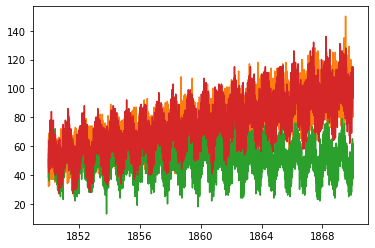

In [2]:
# Generate some data for testing
d1 = np.datetime64('1850-01-01')
d2 = np.datetime64('1870-01-01')
ts = np.arange(d1,d2)

# Constant
curMean = 50 
curBase = poisson.rvs(curMean,size = len(ts))
curBase = curMean * np.ones(len(ts))

# Linearly increasing
curMean2 = 100
allMeans = np.linspace(curMean,curMean2,len(ts))
curBase2 = poisson.rvs(allMeans,size = len(ts))

# Sinusoidal
tDays = (ts -ts[0])/np.timedelta64(1,'D')
sinAmp = 10
sinPer = 2*np.pi/365.25
curBase3 = np.round(poisson.rvs(curMean,size = len(ts)) + sinAmp * np.sin(tDays * sinPer))


# Sinusoidal and linear
tDays = (ts -ts[0])/np.timedelta64(1,'D')
sinAmp = 10
sinPer = 2*np.pi/365.25
curBase4 = np.round(poisson.rvs(allMeans,size = len(ts)) + sinAmp * np.sin(tDays * sinPer))

# Plot
fig,ax = plt.subplots()
ax.plot(ts,curBase)
ax.plot(ts,curBase2)
ax.plot(ts,curBase3)
ax.plot(ts,curBase4)


In [3]:

df = pd.DataFrame(
    index = ts,
    data={
        'Base':curBase,
        'Base2':curBase2,
        'Base3':curBase3,
        'Base4':curBase4,
        }
)

# df.plot()


# Test 

In [4]:
ys = np.arange(
    np.datetime64('1850'),
    np.datetime64('1880'),
)
dfTest = pd.DataFrame(
    index=ys,
    data={
        'Base':10000 * np.ones(len(ys))
    }
)
# dfTest


In [5]:
dfTest.iloc[14] = np.nan 
dfTest

,Base
1850-01-01,10000.0
1851-01-01,10000.0
1852-01-01,10000.0
1853-01-01,10000.0
1854-01-01,10000.0
1855-01-01,10000.0
1856-01-01,10000.0
1857-01-01,10000.0
1858-01-01,10000.0
1859-01-01,10000.0


In [6]:
reload(emf)

<module 'ExcessMortalityFunctions' from 'c:\\NonSyncedFiles\\GithubRepos\\ExcessMortality\\ExcessMortalityFunctions.py'>

In [7]:

curData = dfTest.Base
curData = df.Base
numYears = 5
# # curMean,curStd = emf.rnMean(curData,numYears = numYears,timeResolution='Year')

# pdSeries = curData 
# serYear = pdSeries.groupby(pdSeries.index.year.rename('Year')).sum(min_count=1)
# serYear
# # pdSeries
# # pdSeries.groupby(pdSeries.index.year.rename('Year'))


In [8]:


# curRolling = serYear.rolling(window=(numYears*2)+1,center=True,min_periods=1)
# curSum = curRolling.sum()
# curCount = curRolling.count()

# # curCount = (curCount + serYear.isna() * 1) 
# # serYear.rolling(window=11,center=True,min_periods=1).count()

# curMean = (curSum - serYear.fillna(0))/(curCount-serYear.notna()*1)

# # curMean
# # curCount
# # curSum - serYear.fillna(0)
# # curCount-1
# # (curCount + serYear.isna() * 1) - 1
# # curMean
# # curSum
# # serYear.notna()*1

# # Reshape pivottables into series
# curMean = curMean.reset_index()
# curMean['Date'] = pd.to_datetime(dict(year=curMean.Year,month=np.ones(len(curMean.Year)),day=np.ones(len(curMean.Year))))
# curMean = curMean.sort_values('Date').set_index('Date').drop(columns=['Year']).rename(columns={'value':'Baseline'}).iloc[:,0]

In [9]:

curData = dfTest.Base
curData = df.Base3

curData = emf.removeLeapDays(curData)

curMean,curStd = emf.rnMean(curData,numYears = 5,timeResolution='Year')

curData = emf.groupByYear(curData)

In [10]:
# fig,ax = plt.subplots()
# ax.plot(df.Base3)

In [11]:

# fig,ax = plt.subplots()
# ax.plot(curMean,'k')
# ax.plot(curData,'b.-',lw=0.4)
# ax.plot(curMean+curStd)

# Tests with outliers below

In [12]:
reload(emf)
%matplotlib widget
numYears = 12

In [13]:
dfOut = df.copy()

len(dfOut)
indexToIncrease = np.random.randint(0,len(dfOut),100)

dfOut.iloc[indexToIncrease,:] = dfOut.iloc[indexToIncrease,:]*4
# dfOut

In [14]:
# curData = dfOut.Base4
# curMean,curStd = emf.rnMean(curData,numYears = 12,timeResolution='Month')
# curData = emf.groupByMonth(curData)

curData = dfOut.Base3
curData = curData.rolling(window=7,center=True).mean()

# fig,ax = plt.subplots()
# ax.plot(curData,'.-',ms=2,color='b',lw=0.5)
numYears = 5
curMean,curStd = emf.rnMean(curData,numYears = numYears,timeResolution='Day')



In [15]:
curExc,curZsc = emf.getExcessAndZscore(curData,curMean,curStd)

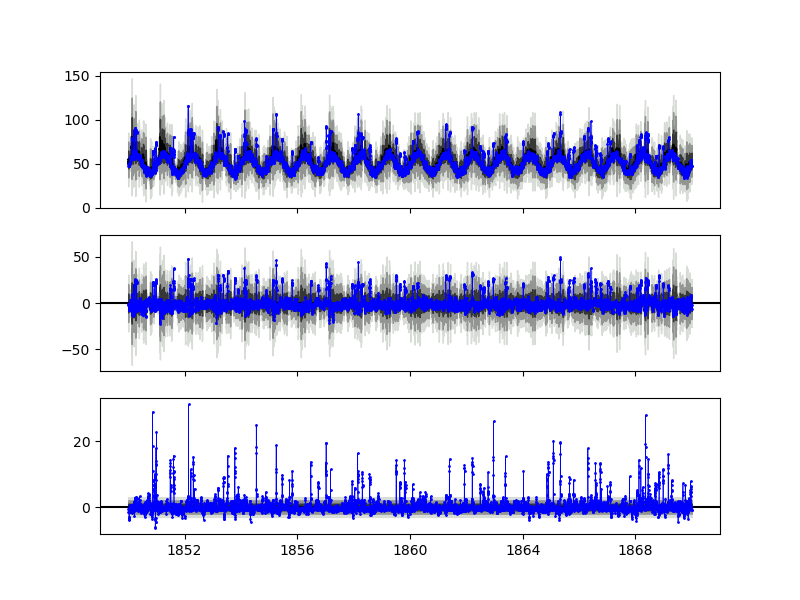

In [16]:
fig,axs = plt.subplots(3,1,figsize=(8,6),sharex=True)
ax1,ax2,ax3 = axs 
ax1.plot(curMean,color='k')
ax1.plot(curData,'.-',ms=2,color='b',lw=0.5)

ax1.fill_between(curData.index,curMean-3*curStd,curMean+3*curStd,color='xkcd:light grey')
ax1.fill_between(curData.index,curMean-2*curStd,curMean+2*curStd,color='xkcd:grey')
ax1.fill_between(curData.index,curMean-curStd,curMean+curStd,color='xkcd:dark grey')


ax2.axhline(0,color='k')
ax2.plot(curExc,'.-',ms=2,color='b',lw=0.5)
ax2.fill_between(curData.index,-3*curStd,+3*curStd,color='xkcd:light grey')
ax2.fill_between(curData.index,-2*curStd,+2*curStd,color='xkcd:grey')
ax2.fill_between(curData.index,-curStd,+curStd,color='xkcd:dark grey')


ax3.axhline(0,color='k')
ax3.plot(curZsc,'.-',ms=2,color='b',lw=0.5)
ax3.fill_between(curData.index,-3*np.ones(curStd.shape),+3*np.ones(curStd.shape),color='xkcd:light grey')
ax3.fill_between(curData.index,-2*np.ones(curStd.shape),+2*np.ones(curStd.shape),color='xkcd:grey')
ax3.fill_between(curData.index,-np.ones(curStd.shape),+np.ones(curStd.shape),color='xkcd:dark grey')



# ax1.set_xlim([
#     np.datetime64('1865-01-01'),
#     np.datetime64('1870-01-01')
# ])
# ax1.plot(curData.loc[curZsc[curZsc > 2].index],'*m')
# ax1.plot(curData.loc[curZsc[curZsc > 3].index],'*r')

In [17]:
curZscoreThreshold = 3

curDataRemove = curData.copy()
curDataRemove.loc[curZsc[curZsc > curZscoreThreshold].index] = np.nan 

# print((curZsc > curZscoreThreshold).sum())
numOutside = (curZsc > curZscoreThreshold).sum()
print(numOutside)

449


In [40]:
reload(emf)

<module 'ExcessMortalityFunctions' from 'c:\\NonSyncedFiles\\GithubRepos\\ExcessMortality\\ExcessMortalityFunctions.py'>

In [86]:
curData = dfOut.Base4.copy()
# curData = curData.rolling(window=7,center=True).mean()
curDataRaw = curData.copy()

In [87]:
numYears = 12

In [88]:

# fig,(ax,ax2) = plt.subplots(2,1,sharex=True,sharey=True)
# ax.plot(curData)
# curMean,curStd = emf.rnMean(curData,numYears=numYears,timeResolution='Day')
# ax.fill_between(curMean.index,curMean - 2* curStd,curMean + 2* curStd,color='xkcd:light grey')
# ax.fill_between(curMean.index,curMean - curStd,curMean + curStd,color='xkcd:grey')
# ax.plot(curMean,'k')

# curData,curMean,curStd = emf.removeAboveThresholdAndRecalculateRepeat(curData,curMean,curStd,ZscoreThreshold=2,numYears=numYears,timeResolution='Day')
# ax2.plot(curData)
# ax2.fill_between(curMean.index,curMean - 2* curStd,curMean + 2* curStd,color='xkcd:light grey')
# ax2.fill_between(curMean.index,curMean - curStd,curMean + curStd,color='xkcd:grey')
# ax2.plot(curMean,'k')

287
149
66
25
11
5
2
0


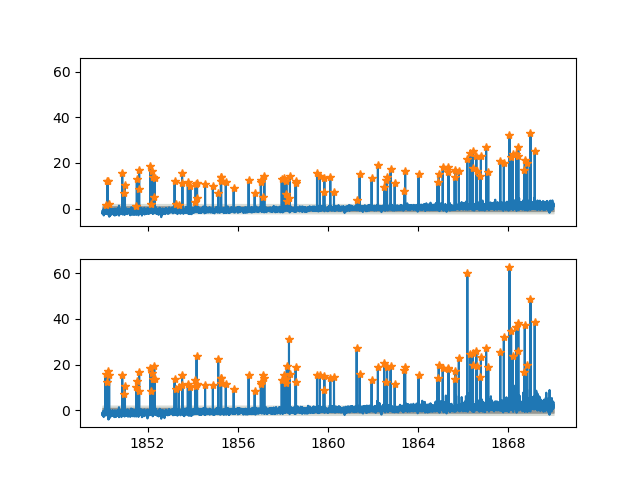

In [89]:

fig,(ax,ax2) = plt.subplots(2,1,sharex=True,sharey=True)
curMean,curStd = emf.rnMean(curData,numYears=numYears,timeResolution='Day')
curExc,curZsc = emf.getExcessAndZscore(curData,curMean,curStd)
ax.plot(curZsc)
ax.fill_between(curMean.index,- 2* np.ones(curStd.shape),+ 2* np.ones(curStd.shape),color='xkcd:light grey')
ax.fill_between(curMean.index,- np.ones(curStd.shape),+ np.ones(curStd.shape),color='xkcd:grey')
# ax.plot(curMean,'k')
ax.plot(curZsc.iloc[indexToIncrease],'*')

curData,curMean,curStd = emf.removeAboveThresholdAndRecalculateRepeat(curData,curMean,curStd,ZscoreThreshold=2,numYears=numYears,timeResolution='Day')
curExc,curZsc = emf.getExcessAndZscore(curData,curMean,curStd)
ax2.plot(curZsc)
ax2.fill_between(curMean.index,- 2* np.ones(curStd.shape),+ 2* np.ones(curStd.shape),color='xkcd:light grey')
ax2.fill_between(curMean.index,- np.ones(curStd.shape),+ np.ones(curStd.shape),color='xkcd:grey')
# ax2.plot(curMean,'k')

ax2.plot(curZsc.iloc[indexToIncrease],'*')

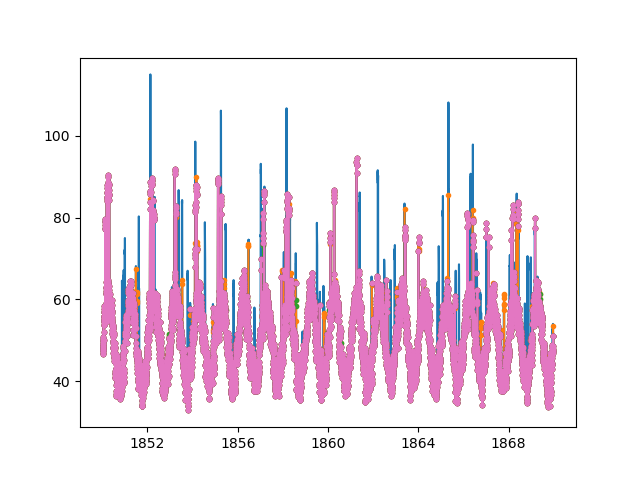

In [23]:

fig,ax = plt.subplots()
ax.plot(curData)
curMean,curStd = emf.rnMean(curData,numYears=numYears,timeResolution='Day')

for k in range(6):
    curData,curMean,curStd = emf.removeAboveThresholdAndRecalculate(curData,curMean,curStd,ZscoreThreshold=3,numYears=numYears,timeResolution='Day')
    ax.plot(curData,'.-')

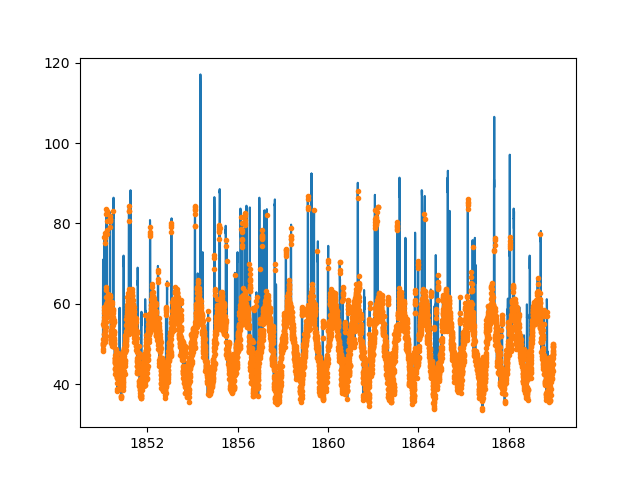

In [702]:
curDataRemove = emf.removeAboveThreshold(curData,curMean,curStd,ZscoreThreshold=3)

fig,ax = plt.subplots()
ax.plot(curData)
ax.plot(curDataRemove,'.-')

In [693]:

while numOutside > 0:

    curMeanRemove,curStdRemove = emf.rnMean(curDataRemove,numYears = numYears,timeResolution='Day')
    curExcRemove,curZscRemove = emf.getExcessAndZscore(curDataRemove,curMeanRemove,curStdRemove)
    # curExcRemove,curZscRemove = emf.getExcessAndZscore(curData,curMeanRemove,curStdRemove)

    curDataRemove.loc[curZscRemove[curZscRemove > curZscoreThreshold].index] = np.nan 
    numOutside = (curZscRemove > curZscoreThreshold).sum()


    # print((curZscRemove > curZscoreThreshold).sum())
    print(numOutside)

157
25
4
0


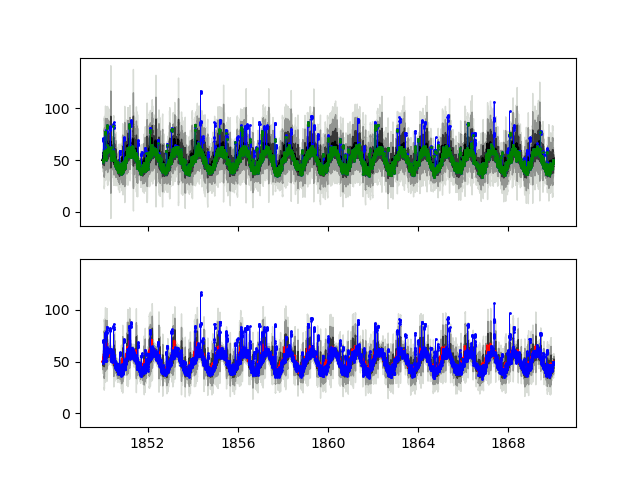

In [696]:
fig,(ax,ax2) = plt.subplots(2,1,sharex=True,sharey=True)
ax.plot(curMean,color='k')
ax2.plot(curMeanRemove,color='r')
# ax.plot(curDataRemove,'.-',ms=2,color='g',lw=0.5)
ax.plot(curData,'.-',ms=2,color='b',lw=0.5)
ax.plot(curDataRemove,'.-',ms=2,color='g',lw=0.5)
ax2.plot(curData,'.-',ms=2,color='b',lw=0.5)

# ax.plot(curMean + curStd,'m',lw=1)
# ax.plot(curMeanRemove + curStdRemove,'g',lw=1)

ax.fill_between(curData.index,curMean-3*curStd,curMean+3*curStd,color='xkcd:light grey')
ax.fill_between(curData.index,curMean-2*curStd,curMean+2*curStd,color='xkcd:grey')
ax.fill_between(curData.index,curMean-1*curStd,curMean+1*curStd,color='xkcd:dark grey')

ax2.fill_between(curData.index,curMeanRemove-3*curStdRemove,curMeanRemove+3*curStdRemove,color='xkcd:light grey')
ax2.fill_between(curData.index,curMeanRemove-2*curStdRemove,curMeanRemove+2*curStdRemove,color='xkcd:grey')
ax2.fill_between(curData.index,curMeanRemove-1*curStdRemove,curMeanRemove+1*curStdRemove,color='xkcd:dark grey')

In [588]:

# # Add columns for year, month and day
# curFrame = dfOut.Base.to_frame()
# curFrame['Year'] = curFrame.index.year 
# curFrame['Month'] = curFrame.index.month
# curFrame['Day'] = curFrame.index.day

# # Organize as pivot-table (with multi-columns)
# curPivot = curFrame.pivot_table(values=dfOut.Base.name,columns=['Month','Day'],index='Year')
# curPivot

In [589]:

# # Add columns for year, month and day
# curFrame = curData.to_frame()
# curFrame['Year'] = curFrame.index.year 
# curFrame['Month'] = curFrame.index.month
# curFrame['Day'] = curFrame.index.day

# # Organize as pivot-table (with multi-columns)
# curPivot = curFrame.pivot_table(values=curData.name,columns=['Month','Day'],index='Year')
# curPivot

In [412]:

# curDataRemoveNoRoll = dfOut.Base
# curDataRemove = curDataRemoveNoRoll.copy()
# curDataRemove = curDataRemove.rolling(window=7,center=True).mean()

numYears = 5
# Add columns for year, month and day
curFrame = curDataRemove.to_frame()
curFrame['Year'] = curFrame.index.year 
curFrame['Month'] = curFrame.index.month
curFrame['Day'] = curFrame.index.day

# Organize as pivot-table (with multi-columns)
curPivot = curFrame.pivot_table(values=curDataRemove.name,columns=['Month','Day'],index='Year')
# curPivot


# Calculate sum of surrounding years and current year
curRolling = curPivot.rolling(window=(numYears*2)+1,center=True,min_periods=1)
curSum = curRolling.sum()
curCount = curRolling.count()
# Calculate mean of surrounding years by subtracting the current year and dividing by the number of surrounding years
curMean = (curSum - curPivot.fillna(0))/(curCount-1)
# curSum
# curCount-1

# Calculate the sum of squares of surrounding years and current year
curRollingSqr = curPivot.pow(2).rolling(window=(numYears*2)+1,center=True,min_periods=1)
curSumSqr = curRollingSqr.sum()
curMeanSqr = (curSumSqr - curPivot.pow(2).fillna(0))/(curCount-1)


# curSumSqr = curPivot.pow(2).rolling(window=(numYears*2)+1,center=True).sum()
# curMeanSqr = (curSumSqr - curPivot.pow(2))/(numYears*2)

# Calculate emperical standard deviation 
curStd = (curMeanSqr - curMean.pow(2).fillna(0)).pow(0.5)

curStd
curSumSqr - curPivot.pow(2).fillna(0)
# curCount
curMeanSqr

Month           1                                                     \
Day             1            2            3       4       5       6    
Year                                                                   
1850   3125.000000  3125.000000  3125.000000  2500.0  2500.0  2500.0   
1851   2500.000000  2500.000000  2500.000000  2500.0  2500.0  2500.0   
1852   2500.000000  2500.000000  2500.000000  2500.0  2500.0  2500.0   
1853   2500.000000  2500.000000  2500.000000  2500.0  2500.0  2500.0   
1854   2500.000000  2500.000000  2500.000000  2500.0  2500.0  2500.0   
1855   2500.000000  2500.000000  2500.000000  2500.0  2500.0  2500.0   
1856   2500.000000  2500.000000  2500.000000  2500.0  2500.0  2500.0   
1857   2500.000000  2500.000000  2500.000000  2500.0  2500.0  2500.0   
1858   2777.777778  2777.777778  2777.777778  2500.0  2500.0  2500.0   
1859   2500.000000  2500.000000  2500.000000  2500.0  2500.0  2500.0   
1860   3180.272109  3180.272109  3180.272109  2500.0  2500.0  2500.0   
1861   3180.272109  3180.272109  3180.272109  2500.0  2500.0  2500.0   
1862   3180.272109  3180.272109  3180.272109  2500.0  2500.0  2500.0   
1863   3180.272109  3180.272109  3180.272109  2500.0  2500.0  2500.0   
1864   3112.244898  3112.244898  3112.244898  2500.0  2500.0  2500.0   
1865   2500.000000  2500.000000  2500.000000  2812.5  2812.5  2500.0   
1866   3265.306122  3265.306122  3265.306122  2500.0  2500.0  2500.0   
1867   3374.635569  3374.635569  3374.635569  2500.0  2500.0  2500.0   
1868   3520.408163  3520.408163  3520.408163  2500.0  2500.0  2500.0   
1869   3724.489796  3724.489796  3724.489796  2500.0  2500.0  2500.0   

Month                                            ...           12  \
Day             7       8       9            10  ...           22   
Year                                             ...                
1850   2500.000000  2500.0  2500.0  2500.000000  ...  2500.000000   
1851   2500.000000  2500.0  2500.0  2500.000000  ...  2500.000000   
1852   2500.000000  2500.0  2500.0  2500.000000  ...  2500.000000   
1853   2500.000000  2500.0  2500.0  2500.000000  ...  2500.000000   
1854   2500.000000  2500.0  2500.0  2500.000000  ...  2500.000000   
1855   2500.000000  2500.0  2500.0  2500.000000  ...  2500.000000   
1856   2500.000000  2500.0  2500.0  2500.000000  ...  2500.000000   
1857   2500.000000  2812.5  2812.5  2857.142857  ...  2500.000000   
1858   2500.000000  2500.0  2500.0  2500.000000  ...  2500.000000   
1859   2500.000000  2500.0  2500.0  2857.142857  ...  2857.142857   
1860   2500.000000  2500.0  2500.0  2500.000000  ...  2857.142857   
1861   2777.777778  2812.5  2812.5  2857.142857  ...  2500.000000   
1862   2500.000000  2500.0  2500.0  2500.000000  ...  2500.000000   
1863   2500.000000  2500.0  2500.0  2500.000000  ...  2500.000000   
1864   2500.000000  2500.0  2500.0  2500.000000  ...  2857.142857   
1865   2500.000000  2500.0  2500.0  2500.000000  ...  2500.000000   
1866   2500.000000  2500.0  2500.0  2500.000000  ...  2500.000000   
1867   2500.000000  2500.0  2500.0  2500.000000  ...  2500.000000   
1868   2500.000000  2500.0  2500.0  2500.000000  ...  2500.000000   
1869   2500.000000  2500.0  2500.0  2500.000000  ...  2500.000000   

Month                                                                   \
Day             23           24           25           26           27   
Year                                                                     
1850   2500.000000  2500.000000  2500.000000  2500.000000  2500.000000   
1851   2500.000000  2500.000000  3000.000000  3000.000000  3000.000000   
1852   2500.000000  2500.000000  2500.000000  2500.000000  2500.000000   
1853   2500.000000  2500.000000  2500.000000  2500.000000  2500.000000   
1854   2500.000000  2500.000000  2825.255102  2825.255102  2825.255102   
1855   2500.000000  2500.000000  3078.231293  3078.231293  3078.231293   
1856   2500.000000  2500.000000  3078.231293  3078.231293  3078.231293   
1857   2500.000

In [361]:
# curPivot
# curCount -1
# curSum - curPivot.fillna(0)
# curSumSqr - curPivot.pow(2).fillna(0)
# curMeanSqr
# curMeanSqr - curMean.pow(2).fillna(0)
# curMean
# curCount

# curPivot

In [358]:
numYears = 5
# Add columns for year, month and day
curFrame = curDataRemove.to_frame()
curFrame['Year'] = curFrame.index.year 
curFrame['Month'] = curFrame.index.month
curFrame['Day'] = curFrame.index.day

# Organize as pivot-table (with multi-columns)
curPivot = curFrame.pivot_table(values=curDataRemove.name,columns=['Month','Day'],index='Year')
curPivot

# Calculate sum of surrounding years and current year
curRolling = curPivot.rolling(window=(numYears*2)+1,center=True,min_periods=1)
curSum = curRolling.sum()
curCount = curRolling.count()
# Calculate mean of surrounding years by subtracting the current year and dividing by the number of surrounding years
curMean = (curSum - curPivot.fillna(0))/(curCount-1)
# curMean = (curSum - curPivot)/(numYears*2)

# Calculate the sum of squares of surrounding years and current year
curRollingSqr = curPivot.pow(2).rolling(window=(numYears*2)+1,center=True,min_periods=1)
curSumSqr = curRollingSqr.sum()
curMeanSqr = (curSumSqr - curPivot.pow(2).fillna(0))/(curCount-1)


# curSumSqr = curPivot.pow(2).rolling(window=(numYears*2)+1,center=True).sum()
# curMeanSqr = (curSumSqr - curPivot.pow(2))/(numYears*2)

# Calculate emperical standard deviation 
curStd = (curMeanSqr - curMean.pow(2).fillna(0)).pow(0.5)

# curPivot.rolling(window=(numYears*2)+1,center=True,min_periods=numYears).count()
# curSum/curCount
# curRolling.mean()
# curCount
# curMean

# curPivot
# curSum - curPivot.fillna(0)

# curRollingSqr.sum()
# curMeanSqr - curM 
# curMeanScurMean.pow(2)
# curStd
curMeanSqr - curMean.pow(2).fillna(0)

curCount 

Month    1                                                        ...   12  \
Day      1     2     3     4     5     6     7     8     9    10  ...   22   
Year                                                              ...        
1850    5.0   5.0   5.0   6.0   6.0   6.0   6.0   6.0   6.0  6.0  ...  6.0   
1851    6.0   6.0   6.0   7.0   7.0   7.0   7.0   7.0   7.0  7.0  ...  7.0   
1852    7.0   7.0   7.0   8.0   8.0   8.0   8.0   7.0   7.0  7.0  ...  8.0   
1853    8.0   8.0   8.0   9.0   9.0   9.0   9.0   8.0   8.0  8.0  ...  9.0   
1854    9.0   9.0   9.0  10.0  10.0  10.0  10.0   9.0   9.0  8.0  ...  9.0   
1855   10.0  10.0  10.0  11.0  11.0  11.0  11.0  10.0  10.0  9.0  ...  9.0   
1856   11.0  11.0  11.0  11.0  11.0  11.0  10.0   9.0   9.0  8.0  ...  9.0   
1857   11.0  11.0  11.0  11.0  11.0  11.0  10.0   9.0   9.0  8.0  ...  9.0   
1858   11.0  11.0  11.0  11.0  11.0  11.0  10.0   9.0   9.0  8.0  ...  9.0   
1859   11.0  11.0  11.0  11.0  11.0  11.0  10.0   9.0   9.0  8.0  ...  8.0   
1860   10.0  10.0  10.0  10.0  10.0  11.0  10.0   9.0   9.0  8.0  ...  8.0   
1861   10.0  10.0  10.0  10.0  10.0  11.0  10.0   9.0   9.0  8.0  ...  8.0   
1862   10.0  10.0  10.0  10.0  10.0  11.0  10.0   9.0   9.0  8.0  ...  8.0   
1863   10.0  10.0  10.0  10.0  10.0  11.0  10.0  10.0  10.0  9.0  ...  8.0   
1864   10.0  10.0  10.0  10.0  10.0  11.0  10.0  10.0  10.0  9.0  ...  8.0   
1865    9.0   9.0   9.0   9.0   9.0  10.0   9.0   9.0   9.0  9.0  ...  8.0   
1866    8.0   8.0   8.0   8.0   8.0   9.0   8.0   8.0   8.0  8.0  ...  8.0   
1867    7.0   7.0   7.0   7.0   7.0   8.0   8.0   8.0   8.0  8.0  ...  7.0   
1868    6.0   6.0   6.0   6.0   6.0   7.0   7.0   7.0   7.0  7.0  ...  6.0   
1869    5.0   5.0   5.0   5.0   5.0   6.0   6.0   6.0   6.0  6.0  ...  5.0   

Month                                                      
Day     23   24    25    26    27    28    29    30    31  
Year                                                       
1850   6.0  6.0   5.0   5.0   5.0   5.0   5.0   5.0   5.0  
1851   7.0  7.0   6.0   6.0   6.0   6.0   6.0   6.0   6.0  
1852   8.0  8.0   7.0   7.0   7.0   7.0   6.0   7.0   7.0  
1853   9.0  9.0   8.0   8.0   8.0   8.0   7.0   8.0   8.0  
1854   9.0  9.0   9.0   9.0   9.0   9.0   8.0   9.0   9.0  
1855   9.0  9.0  10.0  10.0  10.0  10.0   9.0  10.0  10.0  
1856   9.0  9.0  10.0  10.0  10.0  10.0   9.0  10.0  10.0  
1857   9.0  9.0  11.0  11.0  11.0  11.0  10.0  11.0  11.0  
1858   9.0  9.0  11.0  11.0  11.0  11.0  10.0  11.0  11.0  
1859   8.0  8.0  10.0  10.0  10.0  10.0   9.0  10.0  10.0  
1860   8.0  8.0  10.0  10.0  10.0  10.0   9.0  10.0  10.0  
1861   8.0  8.0  10.0  10.0  10.0  10.0   9.0  10.0  10.0  
1862   8.0  8.0  10.0  10.0  10.0  10.0   9.0  10.0  10.0  
1863   8.0  8.0  10.0  10.0  10.0  10.0  10.0  10.0  10.0  
1864   8.0  8.0  10.0  10.0  10.0  10.0   9.0   9.0   9.0  
1865   8.0  8.0   9.0   9.0   9.0   9.0   8.0   8.0   8.0  
1866   8.0  8.0   8.0   8.0   8.0   8.0   7.0   7.0   7.0  
1867   7.0  7.0   7.0   7.0   7.0   7.0   6.0   6.0   6.0  
1868   6.0  6.0   6.0   6.0   6.0   6.0   5.0   5.0   5.0  
1869   5.0  5.0   5.0   5.0   5.0   5.0   4.0   4.0   4.0  

[20 rows x 366 columns]

In [279]:

# For leap days, use the average of February 28th and March 1st (Leap-days in non-leap-years will be removed below anyways)
curMean.loc[:,(2,29)] = (curMean.loc[:,(2,28)] + curMean.loc[:,(3,1)])/2
curStd.loc[:,(2,29)] = (curStd.loc[:,(2,28)] + curStd.loc[:,(3,1)])/2

# Reshape pivottables into series
curMean = curMean.reset_index().melt(id_vars='Year') # Melt pivottable
curMean['Date'] = pd.to_datetime(dict(year=curMean.Year,month=curMean.Month,day=curMean.Day),errors='coerce') # Make a date-columns (coerce "false" leap-days to NaT, i.e. in non-leap years)
curMean = curMean.sort_values('Date').set_index('Date').drop(columns=['Year','Month','Day']).rename(columns={'value':'Baseline'}).iloc[:,0] # Sort by date and drop extra columns
curMean = curMean.loc[curMean.index.notna()] # Remove invalid dates (leap-days in not leap-years)

curStd = curStd.reset_index().melt(id_vars='Year') # Melt pivottable
curStd['Date'] = pd.to_datetime(dict(year=curStd.Year,month=curStd.Month,day=curStd.Day),errors='coerce') # Make a date-columns (coerce "false" leap-days to NaT, i.e. in non-leap years)
curStd = curStd.sort_values('Date').set_index('Date').drop(columns=['Year','Month','Day']).rename(columns={'value':'StandardDeviation'}).iloc[:,0] # Sort by date and drop extra columns
curStd = curStd.loc[curStd.index.notna()] # Remove invalid dates (leap-days in not leap-years)



In [281]:
curStdRemove.loc[np.datetime64('1870-02-21'):].iloc[:20]
# curMeanRemove.loc[np.datetime64('1870-02-21'):].iloc[:20]
curMean.loc[np.datetime64('1870-02-21'):].iloc[:20]
curStd.loc[np.datetime64('1870-02-21'):].iloc[:20]

Date
1870-02-21    10.530227
1870-02-22    11.056916
1870-02-23     9.797643
1870-02-24     9.324614
1870-02-25     9.021656
1870-02-26          NaN
1870-02-27          NaN
1870-02-28          NaN
1870-03-01          NaN
1870-03-02          NaN
1870-03-03          NaN
1870-03-04          NaN
1870-03-05          NaN
1870-03-06          NaN
1870-03-07          NaN
1870-03-08     9.940551
1870-03-09    10.209782
1870-03-10    10.017353
1870-03-11    10.102283
1870-03-12     9.661913
Name: StandardDeviation, dtype: float64

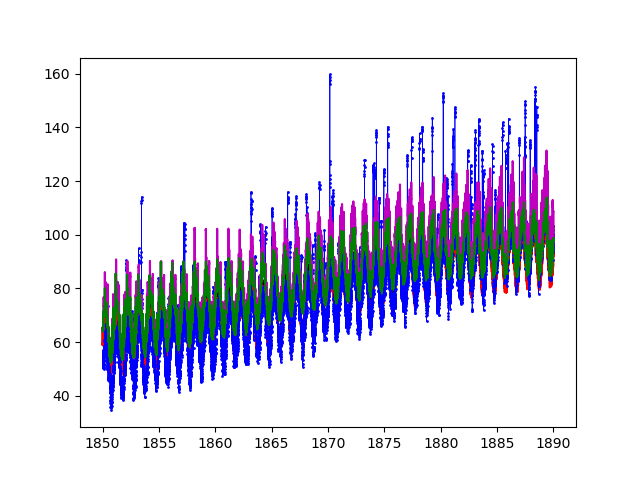

In [267]:
fig,ax = plt.subplots()
ax.plot(curMean,color='k')
ax.plot(curMeanRemove,color='r')
ax.plot(curData,'.-',ms=2,color='b',lw=0.5)

ax.plot(curMean + curStd,'m')
ax.plot(curMeanRemove + curStdRemove,'g')

# ax.fill_between(curData.index,curMeanRemove-3*curStdRemove,curMeanRemove+3*curStdRemove,color='xkcd:light grey')

In [88]:
# pdSeries = dfOut.Base4

# pdSeriesRoll = pdSeries.rolling(window=7,center=True).mean()

# fig,ax = plt.subplots()
# ax.plot(pdSeries)
# ax.plot(pdSeriesRoll)

In [86]:
pdSeries = dfOut.Base4

# pdSeries = pdSeries.rolling(window=7,center=True).mean()

# Add columns for year, month and day
curFrame = pdSeries.to_frame()
curFrame['Year'] = curFrame.index.year 
curFrame['Month'] = curFrame.index.month
curFrame['Day'] = curFrame.index.day

# Organize as pivot-table (with multi-columns)
curPivot = curFrame.pivot_table(values=pdSeries.name,columns=['Month','Day'],index='Year')

# Calculate sum of surrounding years and current year
curSum = curPivot.rolling(window=(numYears*2)+1,center=True).sum()
# Calculate mean of surrounding years by subtracting the current year and dividing by the number of surrounding years
curMean = (curSum - curPivot)/(numYears*2)

# Calculate the sum of squares of surrounding years and current year
curSumSqr = curPivot.pow(2).rolling(window=(numYears*2)+1,center=True).sum()
curMeanSqr = (curSumSqr - curPivot.pow(2))/(numYears*2)

# Calculate emperical standard deviation 
curStd = (curMeanSqr - curMean.pow(2)).pow(0.5)

# For leap days, use the average of February 28th and March 1st (Leap-days in non-leap-years will be removed below anyways)
curMean.loc[:,(2,29)] = (curMean.loc[:,(2,28)] + curMean.loc[:,(3,1)])/2
curStd.loc[:,(2,29)] = (curStd.loc[:,(2,28)] + curStd.loc[:,(3,1)])/2


# fig,ax = plt.subplots()
# ax.plot()
curPivot

Month     1                                                                  \
Day       1      2      3      4      5      6      7      8      9      10   
Year                                                                          
1850    59.0   55.0   50.0   56.0   57.0   52.0   70.0   53.0   55.0   50.0   
1851    54.0   43.0   51.0   60.0   45.0   43.0   52.0   45.0   69.0   52.0   
1852    41.0   48.0   49.0   52.0   52.0   50.0   57.0   43.0   51.0   55.0   
1853    51.0   44.0   58.0   56.0   58.0   43.0   51.0   62.0   52.0   59.0   
1854    40.0   56.0   55.0   47.0   63.0   53.0   57.0   60.0   49.0   63.0   
1855    57.0   46.0   68.0   57.0   63.0   53.0   66.0   58.0   67.0   67.0   
1856    57.0   51.0   45.0   57.0   68.0   54.0   64.0   50.0   59.0   48.0   
1857    58.0   54.0   69.0   67.0   62.0   51.0   47.0   58.0   62.0   55.0   
1858    52.0   66.0   68.0   63.0   62.0   67.0   67.0   66.0   56.0   62.0   
1859    70.0   63.0   71.0   72.0   50.0   58.0   67.0   55.0   65.0   64.0   
1860    66.0   50.0   68.0   68.0   66.0   70.0   66.0   62.0   68.0   60.0   
1861    59.0   77.0   64.0   64.0   62.0   86.0   73.0   67.0   71.0   54.0   
1862    61.0   56.0   65.0   68.0   68.0   72.0   76.0   55.0   47.0   65.0   
1863    62.0   67.0   72.0   69.0   69.0   69.0   68.0   56.0   71.0   73.0   
1864    74.0   68.0   80.0   89.0   63.0   71.0   62.0   71.0   60.0   77.0   
1865    65.0   75.0   84.0   63.0   64.0   78.0   65.0   73.0   78.0   80.0   
1866    82.0   56.0   75.0   70.0   69.0   82.0   79.0   73.0   74.0   83.0   
1867    78.0   78.0   59.0   76.0   71.0   56.0   72.0   81.0   80.0   54.0   
1868    78.0   64.0   65.0   76.0   68.0   74.0   67.0   74.0   81.0   71.0   
1869    71.0   77.0   77.0   85.0   76.0   78.0   78.0   88.0   90.0   81.0   
1870    74.0   73.0   82.0   69.0   93.0   75.0   69.0   77.0   67.0   61.0   
1871    80.0   75.0   80.0   70.0   71.0   82.0   70.0   70.0   73.0   95.0   
1872    64.0   80.0   77.0   82.0   64.0   82.0   72.0   83.0   66.0   66.0   
1873    79.0   80.0   88.0   95.0   61.0   78.0   80.0   82.0   75.0   61.0   
1874    65.0   91.0   88.0   79.0   77.0   89.0   85.0   82.0   85.0   99.0   
1875    91.0   96.0   97.0   73.0   72.0   89.0   91.0   84.0   81.0   85.0   
1876    85.0  104.0   87.0   77.0   91.0   83.0   66.0   94.0   81.0   86.0   
1877    94.0   78.0   79.0   82.0   80.0   93.0   81.0   82.0   98.0   88.0   
1878    77.0   88.0   84.0   75.0  100.0  100.0   82.0   83.0   92.0   84.0   
1879    81.0   86.0   83.0   87.0  103.0   85.0   87.0   75.0   87.0   86.0   
1880    76.0   85.0   94.0   97.0   83.0  104.0   71.0   86.0   84.0   80.0   
1881    97.0   94.0   67.0   74.0   83.0   95.0   94.0  106.0   82.0   83.0   
1882    86.0   75.0   79.0   85.0   93.0   94.0   85.0   81.0  107.0   79.0   
1883    89.0   95.0   65.0   89.0   85.0   84.0   91.0  101.0   97.0   68.0   
1884   110.0  101.0   71.0  110.0   87.0   96.0  103.0   83.0   95.0   91.0   
1885    84.0   91.0   82.0   81.0   94.0  102.0   88.0   89.0   96.0  101.0   
1886    87.0  109.0   87.0  103.0   75.0  119.0   83.0  111.0   93.0  105.0   
1887   108.0   82.0  105.0   84.0  102.0  100.0  103.0   95.0   86.0  106.0   
1888   103.0   92.0  113.0   97.0  110.0   94.0  101.0   97.0  114.0   97.0   
1889   114.0  116.0   81.0   79.0   82.0  108.0   95.0   96.0  100.0   90.0   

Month  ...     12                                                          \
Day    ...     22     23     24     25     26     27     28     29     30   
Year   ...                                                                  
1850   ...   40.0   40.0   50.0   57.0   49.0   66.0   53.0   53.0   52.0   
1851   ...   48.0   53.0   48.0   55.0   52.0   54.0   53.0   45.0   51.0   
1852   ...   49.0   59.0   48.0   59.0   58.0   59.0   49.0   46.0   62.0   
1853   ...   55.0   56.0   55.0   74.0   61.0   54.0   45.0   48.0   54.0   
1854   ...   62.0   61.0   50.0   56.0   54.0   63.0   69.0   6

In [5]:

# pdSeries = df.Base
# curFrame = pdSeries.to_frame()
# curFrame['Year'] = curFrame.index.year 
# curFrame['Month'] = curFrame.index.month
# curFrame['Day'] = curFrame.index.day
# curFrame['Week'] = curFrame.index.isocalendar()
# # curFrame.pivot_table(values=pdSeries.name,index=['Month','Day'],columns='Year')
# # curPivot = curFrame.pivot_table(values=pdSeries.name,columns=['Month','Day'],index='Year')
# # curPivot
# curFrame

In [6]:
pdSeries = df.Base


isoCal = pdSeries.index.isocalendar()


curFrame = pdSeries.to_frame().join(isoCal)
curFrameWeek = curFrame.groupby([curFrame.year,curFrame.week]).sum().drop(columns='day')
curPivot = curFrameWeek.pivot_table(pdSeries.name,index='year',columns='week')


# Calculate sum of surrounding years and current year
curSum = curPivot.rolling(window=(numYears*2)+1,center=True).sum()
# Calculate mean of surrounding years by subtracting the current year and dividing by the number of surrounding years
curMean = (curSum - curPivot)/(numYears*2)

# Calculate the sum of squares of surrounding years and current year
curSumSqr = curPivot.pow(2).rolling(window=(numYears*2)+1,center=True).sum()
curMeanSqr = (curSumSqr - curPivot.pow(2))/(numYears*2)

# Calculate emperical standard deviation 
curStd = (curMeanSqr - curMean.pow(2)).pow(0.5)


# Reshape pivottables into series
curMean = curMean.reset_index().melt(id_vars='year') # Melt pivottable
curMean['Date'] = pd.to_datetime(curMean.year.astype(str)+'-'+curMean.week.astype(str).str.zfill(2)+'-1',format='%G-%V-%w') # Determine date from year and week number
curMean = curMean.sort_values('Date').set_index('Date').drop(columns=['year','week']).rename(columns={'value':'Baseline'}).iloc[:,0] # Sort by date and drop extra columns
curStd = curStd.reset_index().melt(id_vars='year') # Melt pivottable
curStd['Date'] = pd.to_datetime(curStd.year.astype(str)+'-'+curStd.week.astype(str).str.zfill(2)+'-1',format='%G-%V-%w') # Determine date from year and week number
curStd = curStd.sort_values('Date').set_index('Date').drop(columns=['year','week']).rename(columns={'value':'StandardDeviation'}).iloc[:,0] # Sort by date and drop extra columns

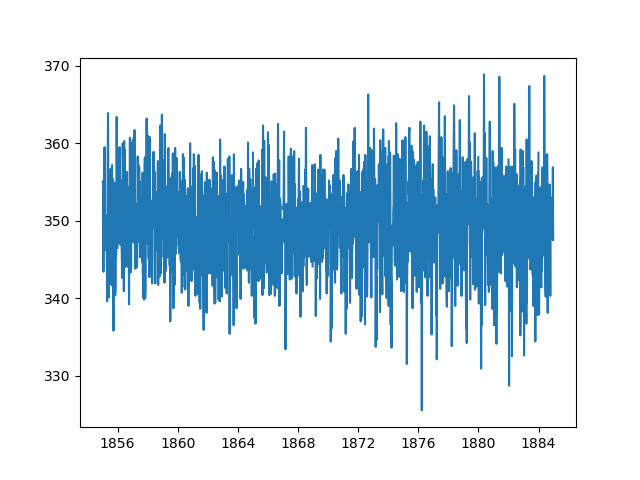

In [7]:
fig,ax = plt.subplots()
ax.plot(curMean)

In [69]:
curMean.year.astype(str)+'-'+curMean.week.astype(str).str.zfill(2)+'-1'

0       1850-01-1
41      1850-02-1
82      1850-03-1
123     1850-04-1
164     1850-05-1
          ...    
2008    1890-49-1
2049    1890-50-1
2090    1890-51-1
2131    1890-52-1
2172    1890-53-1
Length: 2173, dtype: object

In [66]:
# pd.to_datetime('1889-53-1',format='%G-%V-%w')

In [70]:
curMean

,year,week,value,day
0,1850,1,NaN,1.0
41,1850,2,NaN,1.0
82,1850,3,NaN,1.0
123,1850,4,NaN,1.0
164,1850,5,NaN,1.0
...,...,...,...,...
2008,1890,49,NaN,1.0
2049,1890,50,NaN,1.0
2090,1890,51,NaN,1.0
2131,1890,52,NaN,1.0


In [24]:
curData = df.Base4 
curData = df.Base4.rolling(window=7,center=True).mean()
curMean,curStd = emf.rnMean(curData,timeResolution='Day')

TypeError: cannot perform __rmul__ with this index type: DatetimeArray

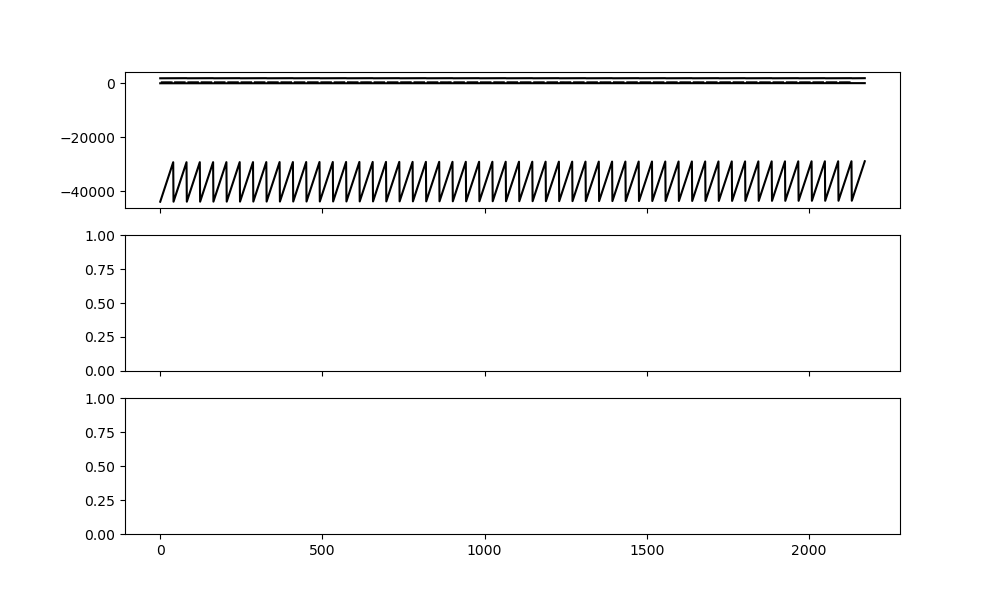

In [88]:

# fig,ax = plt.subplots()
# ax.plot(curMean)
# ax.plot(curData,'.')

fig,(ax,ax2,ax3) = plt.subplots(3,1,figsize=(10,6),sharex=True)
ax.plot(curMean,color='k')
ax.fill_between(x=curMean.index,y1=curMean-3*curStd,y2=curMean+3*curStd,color='xkcd:light gray')
ax.fill_between(x=curMean.index,y1=curMean-2*curStd,y2=curMean+2*curStd,color='xkcd:gray')
ax.fill_between(x=curMean.index,y1=curMean-curStd,y2=curMean+curStd,color='xkcd:dark gray')
ax.plot(curData,'.-',lw=0.5)
# ax.plot(curMean2)
ax2.axhline(0,color='k')
ax2.plot(curData-curMean,'.-',lw=0.5)

ax3.plot((curData-curMean).cumsum())

fig.tight_layout()


In [22]:
numYears = 5

pdSeries = df.Base
curFrame = pdSeries.to_frame()
curFrame['Year'] = curFrame.index.year 
curFrame['Month'] = curFrame.index.month
curFrame['Day'] = curFrame.index.day
# curFrame.pivot_table(values=pdSeries.name,index=['Month','Day'],columns='Year')
curPivot = curFrame.pivot_table(values=pdSeries.name,columns=['Month','Day'],index='Year')
curPivot

# Calculate sum of surrounding years and current year
curSum = curPivot.rolling(window=(numYears*2)+1,center=True).sum()
# Calculate mean of surrounding years by subtracting the current year and dividing by the number of surrounding years
curMean = (curSum - curPivot)/(numYears*2)

# Calculate the sum of squares of surrounding years and current year
curSumSqr = curPivot.pow(2).rolling(window=(numYears*2)+1,center=True).sum()
curMeanSqr = (curSumSqr - curPivot.pow(2))/(numYears*2)

# Calculate emperical standard deviation 
curStd = (curMeanSqr - curMean.pow(2)).pow(0.5)

curMean.iloc[:,50:]


# # Reshape pivottables into series
# curMean = curMean.reset_index().melt(id_vars='Year') # Melt pivottable
# curMean['Date'] = pd.to_datetime(dict(year=curMean.Year,month=curMean.Month,day=curMean.Day),errors='coerce') # Make a date-columns (coerce "false" leap-days to NaT, i.e. in non-leap years)
# curMean = curMean.sort_values('Date').set_index('Date').drop(columns=['Year','Month','Day']).rename(columns={'value':'Baseline'}).iloc[:,0] # Sort by date and drop extra columns
# curMean = curMean.loc[curMean.index.notna()] # Remove invalid dates (leap-days in not leap-years)
# # curStd = curStd.reset_index().melt(id_vars='Year')
# # curStd['Date'] = pd.to_datetime(dict(year=curStd.Year,month=curStd.Month,day=np.ones(len(curStd.Year))))
# # curStd = curStd.sort_values('Date').set_index('Date').drop(columns=['Year','Month']).rename(columns={'value':'StandardDeviation'}).iloc[:,0]

# # curMean = curMean[~(curMean.Day == 29) & (curMean.Month == 2)] 

curMean.loc[:,(2,29)] = (curMean.loc[:,(2,28)] + curMean.loc[:,(3,1)])/2
curMean.iloc[:,55:]

Month    2                              3                           ...    12  \
Day      25    26    27    28     29    1     2     3     4     5   ...    22   
Year                                                                ...         
1850    NaN   NaN   NaN   NaN    NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
1851    NaN   NaN   NaN   NaN    NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
1852    NaN   NaN   NaN   NaN    NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
1853    NaN   NaN   NaN   NaN    NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
1854    NaN   NaN   NaN   NaN    NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
1855   49.6  47.4  51.1  51.8  53.95  56.1  49.6  51.9  46.9  50.0  ...  49.1   
1856   52.2  48.5  50.8  51.8  53.60  55.4  48.4  47.8  49.3  51.4  ...  46.9   
1857   51.9  45.8  51.0  49.6  52.30  55.0  48.6  48.5  48.8  51.3  ...  48.5   
1858   53.6  46.4  49.6  50.7  51.70  52.7  48.4  47.2  49.0  50.7  ...  48.4   
1859   52.9  47.1  47.0  48.8  51.35  53.9  47.2  49.0  49.7  47.1  ...  49.1   
1860   51.4  46.8  48.9  48.4  50.40  52.4  48.5  49.5  48.8  46.5  ...  48.1   
1861   50.5  46.5  50.4  48.8  51.90  55.0  50.9  51.1  48.1  44.8  ...  50.0   
1862   51.5  48.9  49.2  49.7  52.40  55.1  49.3  49.0  48.1  47.6  ...  48.6   
1863   51.4  48.3  51.8  47.4  51.90  56.4  48.5  48.2  48.0  47.2  ...  48.1   
1864   53.1  49.3  50.6  47.8  50.75  53.7  49.2  46.3  47.4  48.7  ...  48.9   
1865   54.6  50.6  47.7  47.8  51.15  54.5  46.6  46.3  48.5  48.0  ...  50.7   
1866   52.1  50.4  47.4  45.7  49.60  53.5  45.7  47.6  47.3  49.2  ...  50.9   
1867   50.7  50.6  48.4  45.9  49.75  53.6  49.4  50.1  49.0  47.2  ...  52.8   
1868   48.9  52.5  48.5  47.3  50.10  52.9  48.8  52.9  49.3  47.3  ...  53.7   
1869   47.7  52.8  53.0  46.8  51.05  55.3  49.5  54.4  49.2  48.1  ...  53.7   
1870   46.9  54.3  52.6  46.1  50.35  54.6  50.7  54.3  48.7  49.8  ...  52.5   
1871   49.9  54.2  52.6  47.5  51.45  55.4  49.5  52.3  50.5  50.9  ...  53.8   
1872   49.2  54.0  52.2  46.4  50.40  54.4  46.0  51.3  48.1  52.7  ...  54.1   
1873   48.5  53.2  52.5  45.7  49.60  53.5  48.0  49.9  49.4  52.8  ...  54.6   
1874   46.7  51.1  50.8  45.2  49.35  53.5  46.7  49.8  48.2  50.4  ...  54.4   
1875   46.1  50.4  51.8  46.0  49.90  53.8  47.9  50.9  48.0  51.0  ...  55.6   
1876   42.8  51.8  51.2  45.1  48.65  52.2  49.0  52.2  46.7  51.4  ...  52.6   
1877   44.9  51.0  50.6  45.9  50.05  54.2  50.4  51.2  50.9  52.5  ...  52.6   
1878   46.2  51.4  48.1  46.2  50.25  54.3  48.3  51.4  49.6  51.7  ...  51.8   
1879   46.7  52.7  48.9  47.9  49.90  51.9  49.6  50.3  51.4  53.2  ...  50.8   
1880   46.5  50.1  49.0  46.0  49.15  52.3  48.1  49.4  52.1  50.9  ...  50.6   
1881   48.5  49.5  46.9  48.8  50.10  51.4  48.6  47.1  52.5  50.3  ...  51.5   
1882   46.9  49.1  47.5  49.8  49.20  48.6  48.3  47.6  49.4  47.6  ...  48.4   
1883   48.2  48.6  47.5  50.3  49.50  48.7  50.0  46.7  50.6  50.5  ...  48.7   
1884   49.7  49.3  44.9  49.9  50.25  50.6  49.4  49.4  51.5  50.0  ...  49.1   
1885    NaN   NaN   NaN   NaN    NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
1886    NaN   NaN   NaN   NaN    NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
1887    NaN   NaN   NaN   NaN    NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
1888    NaN   NaN   NaN   NaN    NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
1889    NaN   NaN   NaN   NaN    NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   

Month                                                        
Day      23    24    25    26    27    28    29    30    31  
Year                                                         
1850    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
1851    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
1852    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
1853    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
1854    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
1855   53.1  45.8  4

In [228]:
df.groupby(pd.Grouper(freq='1M')).sum()
dfMonth = df.groupby([df.index.year.rename('Year'),df.index.month.rename('Month')]).sum()
dfMonth


Base  Base2   Base3   Base4
Year Month                             
1850 1      1520   1541  1562.0  1727.0
     2      1393   1345  1628.0  1609.0
     3      1559   1601  1878.0  1824.0
     4      1516   1523  1774.0  1821.0
     5      1585   1626  1783.0  1713.0
...          ...    ...     ...     ...
1889 8      1479   3086  1292.0  2892.0
     9      1493   2969  1220.0  2646.0
     10     1536   3093  1243.0  2784.0
     11     1486   3017  1309.0  2747.0
     12     1579   3171  1491.0  3033.0

[480 rows x 4 columns]

In [229]:

# curTest  = df.Base

# # # # Start by grouping data by month, in case its daily
# curTest = curTest.groupby([curTest.index.year.rename('Year'),curTest.index.month.rename('Month')]).sum()
# curTest = curTest.reset_index()
# # # curTest = curTest.reset_index().melt(id_vars='Year')
# curTest['Date'] = pd.to_datetime(dict(year=curTest.Year,month=curTest.Month,day=np.ones(len(curTest.Year))))
# # curTest = curTest.sort_values('Date').set_index('Date').drop(columns=['Year','Month']).rename(columns={'Base':'Baseline'})

# curTest = curTest.drop(columns=['Year','Month']).set_index('Date')
# curTest = curTest.iloc[:,0]

In [230]:
# curData-curMean
# curData 


In [231]:
pdSeries = df.Base
serMonth = pdSeries.groupby([pdSeries.index.year.rename('Year'),pdSeries.index.month.rename('Month')]).sum()
serMonth

Year  Month
1850  1        1520
      2        1393
      3        1559
      4        1516
      5        1585
               ... 
1889  8        1479
      9        1493
      10       1536
      11       1486
      12       1579
Name: Base, Length: 480, dtype: int32

In [243]:
pdSeries = df.Base2
serYear = pdSeries.groupby(pdSeries.index.year.rename('Year')).sum()
serYear.rolling(window=7).sum()

numYears = 5
# Calculate sum of surrounding years and current year
curSum = serYear.rolling(window=(numYears*2)+1,center=True).sum()
# Calculate mean of surrounding years by subtracting the current year and dividing by the number of surrounding years
curMean = (curSum - serYear)/(numYears*2)

# Calculate the sum of squares of surrounding years and current year
curSumSqr = serYear.pow(2).rolling(window=(numYears*2)+1,center=True).sum()
curMeanSqr = (curSumSqr - serYear.pow(2))/(numYears*2)

# Calculate emperical standard deviation 
curStd = (curMeanSqr - curMean.pow(2)).pow(0.5)

curData = emf.groupByYear(pdSeries)


curMean = curMean.reset_index()
curMean['Date'] = pd.to_datetime(dict(year=curMean.Year,month=np.ones(len(curMean.Year)),day=np.ones(len(curMean.Year))))
curMean = curMean.sort_values('Date').set_index('Date').drop(columns=['Year']).rename(columns={'value':'Baseline'}).iloc[:,0]
curMean
# serYear

Date
1850-01-01        NaN
1851-01-01        NaN
1852-01-01        NaN
1853-01-01        NaN
1854-01-01        NaN
1855-01-01    20760.6
1856-01-01    21253.8
1857-01-01    21710.0
1858-01-01    22160.3
1859-01-01    22578.6
1860-01-01    23031.5
1861-01-01    23484.1
1862-01-01    23954.4
1863-01-01    24426.0
1864-01-01    24895.4
1865-01-01    25370.5
1866-01-01    25770.5
1867-01-01    26226.2
1868-01-01    26677.9
1869-01-01    27141.9
1870-01-01    27584.0
1871-01-01    28135.1
1872-01-01    28564.2
1873-01-01    29002.8
1874-01-01    29438.8
1875-01-01    29894.0
1876-01-01    30290.9
1877-01-01    30809.2
1878-01-01    31272.0
1879-01-01    31729.4
1880-01-01    32124.8
1881-01-01    32533.8
1882-01-01    32986.1
1883-01-01    33456.3
1884-01-01    33920.4
1885-01-01        NaN
1886-01-01        NaN
1887-01-01        NaN
1888-01-01        NaN
1889-01-01        NaN
Name: Base2, dtype: float64

In [246]:
curMean

curMean,curStd = emf.rnMean(df.Base2,timeResolution='Year')
curData = emf.groupByYear(df.Base2)
# curData
# curMean
# # curStd
# # curMean - curData 
# curMean 
# curData.index

In [267]:
pdSeries.index[((curDates.month == 2) & (curDates.day == 29))]

DatetimeIndex(['1852-02-29', '1856-02-29', '1860-02-29', '1864-02-29',
               '1868-02-29', '1872-02-29', '1876-02-29', '1880-02-29',
               '1884-02-29', '1888-02-29'],
              dtype='datetime64[ns]', freq=None)

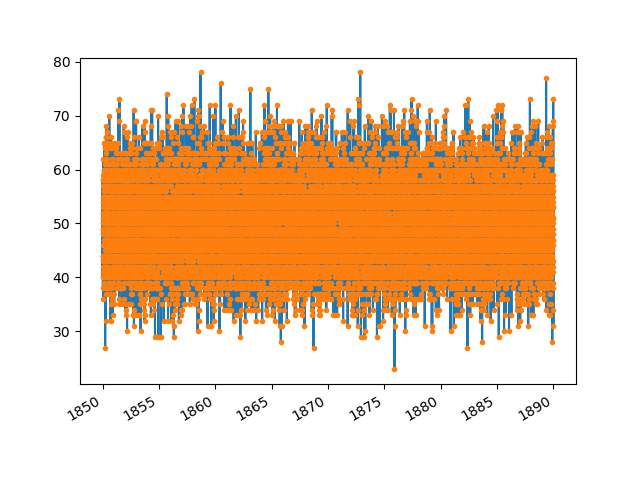

In [269]:
pdSeries = df.Base
curDates = pdSeries.index
nonLeapDay = ~((curDates.month == 2) & (curDates.day == 29))
pdSeries.loc[nonLeapDay]

fig,ax = plt.subplots()
pdSeries.loc[nonLeapDay].plot(ax=ax)
ax.plot(pdSeries.loc[nonLeapDay],'.')

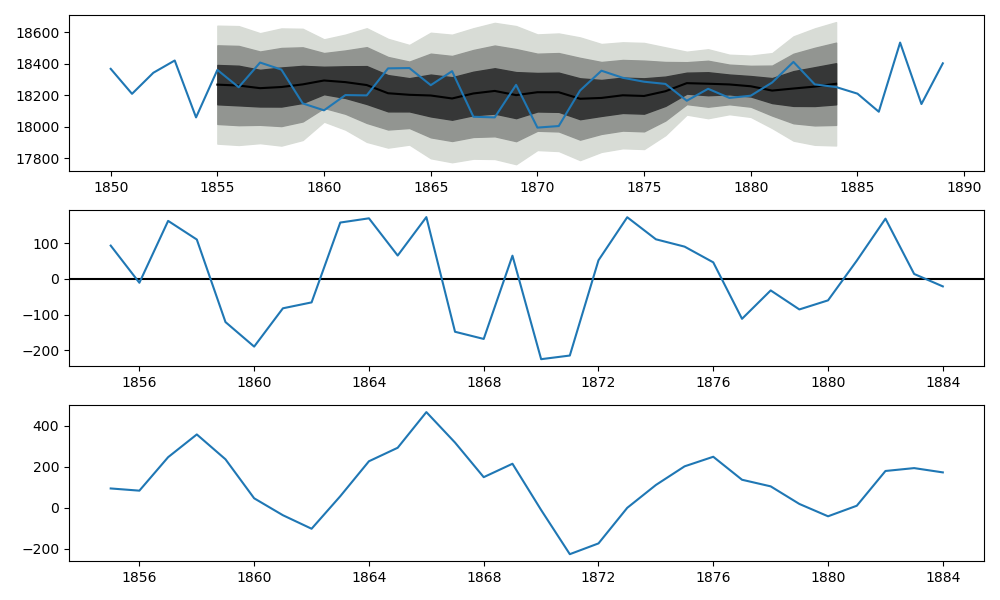

In [254]:

curData = emf.groupByYear(df.Base3)
curMean,curStd = emf.rnMean(curData,timeResolution='Year')

fig,(ax,ax2,ax3) = plt.subplots(3,1,figsize=(10,6))
ax.plot(curMean,color='k')
ax.fill_between(x=curMean.index,y1=curMean-3*curStd,y2=curMean+3*curStd,color='xkcd:light gray')
ax.fill_between(x=curMean.index,y1=curMean-2*curStd,y2=curMean+2*curStd,color='xkcd:gray')
ax.fill_between(x=curMean.index,y1=curMean-curStd,y2=curMean+curStd,color='xkcd:dark gray')
ax.plot(curData)
# ax.plot(curMean2)
ax2.axhline(0,color='k')
ax2.plot(curData-curMean)

ax3.plot((curData-curMean).cumsum())

fig.tight_layout()

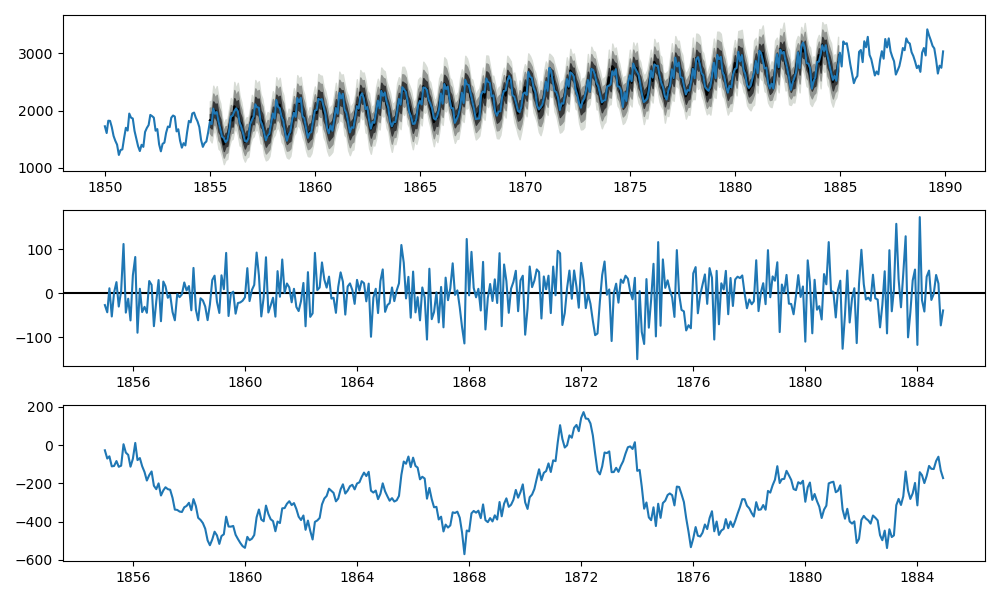

In [235]:
# curData = df['Base']
curData = emf.groupByMonth(df['Base4'])
curMean,curStd = emf.rnMean(curData)
# curMean2,curStd2 = emf.rnMean(curData)

%matplotlib widget
fig,(ax,ax2,ax3) = plt.subplots(3,1,figsize=(10,6))
ax.plot(curMean,color='k')
ax.fill_between(x=curMean.index,y1=curMean-3*curStd,y2=curMean+3*curStd,color='xkcd:light gray')
ax.fill_between(x=curMean.index,y1=curMean-2*curStd,y2=curMean+2*curStd,color='xkcd:gray')
ax.fill_between(x=curMean.index,y1=curMean-curStd,y2=curMean+curStd,color='xkcd:dark gray')
ax.plot(curData)
# ax.plot(curMean2)
ax2.axhline(0,color='k')
ax2.plot(curData-curMean)

ax3.plot((curData-curMean).cumsum())

fig.tight_layout()

# # curMean.melt(id_vars=['index'])
# curMean = curMean.reset_index().melt(id_vars='Year')
# curMean['Date'] = pd.to_datetime(dict(year=curMean.Year,month=curMean.Month,day=np.ones(len(curMean.Year))))

# curMean.sort_values('Date').set_index('Date').drop(columns=['Year','Month']).rename(columns={'value':'Baseline'})

In [236]:
pdSeries = df.Base 
numYears = 5 

# Start by grouping data by month, in case its daily
serMonth = pdSeries.groupby([pdSeries.index.year.rename('Year'),pdSeries.index.month.rename('Month')]).sum()

# Organize as pivot table
curPivot = serMonth.to_frame().pivot_table('Base',index='Year',columns='Month')

# Calculate sum of surrounding years and current year
curSum = curPivot.rolling(window=(numYears*2)+1,center=True).sum()
# Calculate mean of surrounding years by subtracting the current year and dividing by the number of surrounding years
curMean = (curSum - curPivot)/(numYears*2)

# Calculate the sum of squares of surrounding years and current year
curSumSqr = curPivot.pow(2).rolling(window=(numYears*2)+1,center=True).sum()
curMeanSqr = (curSumSqr - curPivot.pow(2))/(numYears*2)

# Calculate emperical standard deviation 
curStd = (curMeanSqr - curMean.pow(2)).pow(0.5)

In [237]:
# curMean.T.plot()


In [238]:

# # dfMonth.loc[1850:1852]

# curSeries = df['Base']
# serMonth = curSeries.groupby([curSeries.index.year.rename('Year'),curSeries.index.month.rename('Month')]).sum()
# # serMonth.pivot_table('Base',index='Year',columns='Month')
# curPivot = serMonth.to_frame().pivot_table('Base',index='Year',columns='Month')

# numYears = 2
# (curPivot.rolling(window=(numYears*2)+1,center=True).sum() - curPivot)/(numYears*2)

# curMean,curStd = emf.rnMean(df['Base'])
# curStd
pdSeries = df['Base']
numYears = 5

# Start by grouping data by month, in case its daily
serMonth = pdSeries.groupby([pdSeries.index.year.rename('Year'),pdSeries.index.month.rename('Month')]).sum()

# Organize as pivot table
curPivot = serMonth.to_frame().pivot_table('Base',index='Year',columns='Month')

# Calculate sum of surrounding years and current year
curSum = curPivot.rolling(window=(numYears*2)+1,center=True).sum()
# Calculate mean of surrounding years by subtracting the current year and dividing by the number of surrounding years
curMean = (curSum - curPivot)/(numYears*2)

# Calculate the sum of squares of surrounding years and current year
curSumSqr = curPivot.pow(2).rolling(window=(numYears*2)+1,center=True).sum()
curMeanSqr = (curSumSqr - curPivot.pow(2))/(numYears*2)

# Calculate emperical standard deviation 
curStd = (curMeanSqr - curMean.pow(2)).pow(0.5)

# curBase = (curPivot.rolling(window=(2*numYears)+1,center=True).sum() - curPivot)/(2*numYears)
# curBase2 = (curPivot.pow(2).rolling(window=(numYears*2)+1,center=True).sum() - curPivot.pow(2))/(numYears*2)


# curBase2 - curBase.pow(2)
# # curBase2.loc[1860]
# # curMeanSqr.loc[1860]
# # curMeanSqr.pow(0.5)
# # curPivot.pow(2)
# # curSumSqr
# # curBase 
# # curBase2
curStd

Month,1,2,3,4,5,6,7,8,9,10,11,12
Year,,,,,,,,,,,,
1850,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1851,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1852,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1853,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1854,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1855,47.278325,37.757781,22.697136,23.724460,42.174518,27.209557,35.905571,21.111371,23.752895,25.277658,35.997361,22.668039
1856,45.948232,40.830013,24.220033,27.171492,39.843318,23.148434,36.030681,35.445874,22.351957,26.485656,32.109812,20.730654
1857,42.677980,41.759310,42.270084,26.783577,45.771170,24.713559,38.003158,35.520276,35.970683,27.202206,32.328934,25.377155
1858,40.187685,29.336155,42.650791,26.858146,45.122500,22.291030,34.767945,36.733636,33.440096,30.434191,30.391611,26.452977


In [239]:

# dfMonth.loc[1850:1860]
# dfMonth.xs(12,level=1).pivot_table('Base')
# dfMonth.pivot('Base')
# dfMonth.unstack()

curPivot = dfMonth.pivot_table('Base',index='Year',columns='Month')
# dfMonth.pivot_table('Base',index='Month',columns='Year')


curPivot = curPivot.iloc[:11,:]

# curPivot.rolling(window=numYears)

In [240]:

numYears = 2
(curPivot.rolling(window=(numYears*2)+1,center=True).sum() - curPivot)/(numYears*2)

Month,1,2,3,4,5,6,7,8,9,10,11,12
Year,,,,,,,,,,,,
1850,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1851,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1852,1565.00,1397.50,1544.50,1482.75,1552.75,1487.25,1551.50,1514.75,1503.75,1531.25,1519.75,1550.50
1853,1539.25,1394.25,1549.25,1498.25,1559.00,1501.25,1524.25,1535.00,1486.25,1554.75,1501.75,1550.00
1854,1567.75,1407.75,1547.00,1497.00,1565.50,1497.00,1546.25,1550.50,1497.50,1563.25,1508.00,1559.50
1855,1582.50,1399.75,1547.25,1482.25,1572.00,1481.25,1549.50,1522.25,1509.25,1556.50,1517.75,1547.75
1856,1561.75,1408.75,1536.50,1500.00,1553.75,1492.75,1543.75,1548.25,1510.75,1565.75,1498.50,1551.00
1857,1569.75,1411.00,1530.75,1503.25,1565.25,1504.25,1550.75,1565.50,1517.00,1568.00,1518.50,1557.25
1858,1570.50,1406.50,1538.75,1505.25,1570.75,1503.75,1547.25,1535.50,1501.25,1572.25,1508.75,1533.75
